# 🎓 Student Score Prediction — End-to-End ML Notebook

**Internship Task**  
<p style="color: #2e7d32; font-weight: bold;">Predict students' exam scores based on study hours and other factors.</p>

- **Dataset**: <a href="https://www.kaggle.com/datasets/dishantkhanna/student-performance-factors" style="color: #0288d1;">Student Performance Factors (Kaggle)</a>  
- **Tools**: Python, Pandas, Matplotlib, Scikit-learn  
- **Topics**: Regression, Evaluation Metrics  
- **Bonus**: Polynomial Regression + Feature Experimentation  

**Created**: <span style="color: #d81b60;">2025-08-13</span>  

---

### 📊 Project Overview  
<div style="background-color: #e8f5e9; padding: 15px; border-radius: 10px; border: 2px solid #4caf50;">
  <p style="color: #1b5e20;">The goal is to build a regression model to predict <b>Exam_Score</b> using features like <b>Hours_Studied</b>, <b>Sleep_Hours</b>, and <b>Attendance</b>. We'll preprocess the data, train a linear regression model, evaluate it, and experiment with polynomial regression for improved accuracy.</p>
</div>

## 0. Environment Setup & Imports
This cell imports the required libraries. If something is missing, install via `pip` in this notebook or your environment.

In [1]:

# Core libraries
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)
print('Libraries imported successfully.')

Libraries imported successfully.


## 1. Data Loading
### Option A (Recommended): Load the Kaggle *Student Performance Factors* dataset
- Export the dataset from Kaggle as a CSV file (e.g., `student_performance_factors.csv`).
- Place it in the same directory as this notebook **or** upload via the widget below.

### Option B: Use synthetic demo data (for quick runs)
If you don't have the file, run the synthetic generator cell and continue.

In [2]:

# Configure your expected CSV file name here (edit if needed)
CSV_PATH = 'student_performance_factors.csv'

# If running in an environment that supports file upload, you can use this fallback:
try:
    from IPython.display import display
    import ipywidgets as widgets

    uploader = widgets.FileUpload(accept='.csv', multiple=False, description='Upload CSV')
    display(uploader)
except Exception as e:
    print('Upload widget unavailable in this environment:', e)


FileUpload(value={}, accept='.csv', description='Upload CSV')

In [3]:

# Helper: load from path or from uploaded widget
def load_dataset(csv_path='student_performance_factors.csv', uploader_widget=None):
    # 1) Try reading from path
    if os.path.exists(csv_path):
        print(f'Reading dataset from: {csv_path}')
        df = pd.read_csv(csv_path)
        return df

    # 2) Try reading from upload widget (if provided and has content)
    if uploader_widget is not None and len(uploader_widget.value) > 0:
        # Grab the first uploaded file
        key = list(uploader_widget.value.keys())[0]
        content = uploader_widget.value[key]['content']
        df = pd.read_csv(io.BytesIO(content))
        print(f'Read dataset from uploaded file: {key}')
        return df

    # 3) If neither exists, return None and handle downstream
    print('No dataset found at path and nothing uploaded yet.')
    return None

df = load_dataset(CSV_PATH, uploader if 'uploader' in globals() else None)
df.head() if df is not None else None


No dataset found at path and nothing uploaded yet.


### 1.1 Synthetic Dataset (Fallback)
Run this if you don't have the Kaggle CSV yet. This creates a small dataset with `study_hours`, `sleep_hours`, `attendance`, and a target `final_score`.

In [4]:

def generate_synthetic_student_data(n=400, random_state=42):
    rng = np.random.default_rng(random_state)
    study_hours = rng.normal(4.5, 1.5, n).clip(0.5, 10)
    sleep_hours = rng.normal(7.0, 1.0, n).clip(4.0, 10)
    attendance = rng.uniform(60, 100, n)
    participation = rng.integers(0, 2, n)  # 0/1
    # Construct target with noise
    noise = rng.normal(0, 5, n)
    final_score = (study_hours * 10) + (sleep_hours * 2) + (attendance * 0.2) + (participation * 3) + noise
    final_score = final_score.clip(0, 100)

    demo = pd.DataFrame({
        'study_hours': study_hours,
        'sleep_hours': sleep_hours,
        'attendance': attendance,
        'participation': participation,
        'final_score': final_score
    })
    return demo

if 'df' not in globals() or df is None:
    print('Generating synthetic dataset...')
    df = generate_synthetic_student_data()
    print('Synthetic dataset created.')

df.head()


Generating synthetic dataset...
Synthetic dataset created.


,study_hours,sleep_hours,attendance,participation,final_score
0,4.957076,6.820389,84.430805,0,76.738134
1,2.940024,7.196776,82.141634,0,67.609085
2,5.625677,7.820528,75.846660,0,84.354368
3,5.910847,6.606259,87.104831,1,95.053017
4,1.573447,7.521167,89.030785,0,39.226873


## 2. Quick Data Overview & Cleaning
We inspect shape, missing values, basic stats, and make minimal cleaning decisions (drop duplicates, handle NAs).

In [5]:

print('Shape:', df.shape)
display(df.head(10))
display(df.describe(include='all'))

# Basic cleaning
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f'Dropped {before - after} duplicate rows.')

# Handle missing values: simple strategy -> drop rows with NA in key columns
na_before = df.isna().sum().sum()
df = df.dropna()
na_after = df.isna().sum().sum()
print(f'Removed {na_before - na_after} NA values by dropping rows with NA.')

Shape: (400, 5)


,study_hours,sleep_hours,attendance,participation,final_score
0,4.957076,6.820389,84.430805,0,76.738134
1,2.940024,7.196776,82.141634,0,67.609085
2,5.625677,7.820528,75.846660,0,84.354368
3,5.910847,6.606259,87.104831,1,95.053017
4,1.573447,7.521167,89.030785,0,39.226873
5,2.546731,6.734161,82.677512,0,64.782720
6,4.691761,6.882458,90.336889,0,81.763162
7,4.025636,7.829519,99.336683,1,77.870237
8,4.474798,5.006940,76.770896,0,72.993774
9,3.220434,5.703528,80.583322,0,52.678964


,study_hours,sleep_hours,attendance,participation,final_score
count,400.000000,400.000000,400.000000,400.00000,400.000000
mean,4.492220,6.947571,80.427976,0.48750,75.456506
std,1.428517,1.015929,11.566486,0.50047,14.243476
min,0.650012,4.035471,60.020750,0.00000,29.886736
25%,3.499624,6.216546,70.129510,0.00000,65.712722
50%,4.525760,6.961470,80.098895,0.00000,75.711783
75%,5.393055,7.627657,90.426350,1.00000,85.290914
max,8.870794,9.597674,99.976876,1.00000,100.000000


Dropped 0 duplicate rows.
Removed 0 NA values by dropping rows with NA.


## 3. Basic Visualization
We visualize the relationship between **study hours** and **final score**.

> Note: If your dataset uses different column names (e.g., `Hours_Studied`, `Exam_Score`),
the next cell tries to detect them automatically.

Detected columns -> study: study_hours , score: final_score


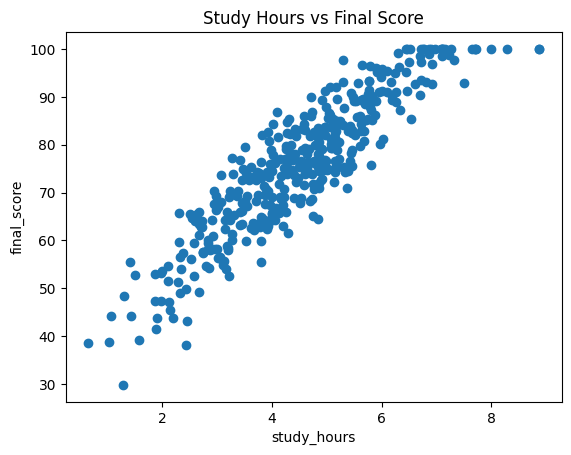

In [6]:

# Try to auto-detect likely column names case-insensitively
def find_column(candidates, df_cols):
    df_cols_lower = {c.lower(): c for c in df_cols}
    for cand in candidates:
        c_lower = cand.lower()
        if c_lower in df_cols_lower:
            return df_cols_lower[c_lower]
    return None

study_candidates = ['study_hours', 'hours_studied', 'studyhours', 'hours', 'studytime']
score_candidates = ['final_score', 'exam_score', 'score', 'marks', 'target']

study_col = find_column(study_candidates, df.columns)
score_col = find_column(score_candidates, df.columns)

print('Detected columns -> study:', study_col, ', score:', score_col)

if study_col is None or score_col is None:
    raise ValueError('Could not detect study or score columns. Please rename columns or update candidates.')

# Scatter plot
plt.figure()
plt.scatter(df[study_col], df[score_col])
plt.title('Study Hours vs Final Score')
plt.xlabel(study_col)
plt.ylabel(score_col)
plt.show()


## 4. Train/Test Split
We use only **study hours** to predict **final score** (baseline model), as required.
You can switch to multiple features later for experimentation.

In [7]:

# Baseline features: only study hours
X = df[[study_col]].copy()
y = df[score_col].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape


((320, 1), (80, 1))

## 5. Linear Regression (Baseline)
Train a standard Linear Regression model and evaluate it on the test set.

In [9]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Calculate RMSE manually
r2 = r2_score(y_test, y_pred)

print('--- Linear Regression (baseline: study_hours only) ---')
print(f'MAE : {mae:.3f}')
print(f'MSE : {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'R^2 : {r2:.3f}')

--- Linear Regression (baseline: study_hours only) ---
MAE : 4.437
MSE : 28.948
RMSE: 5.380
R^2 : 0.841


### 5.1 Visualize Predictions
We plot the test points and the fitted line.

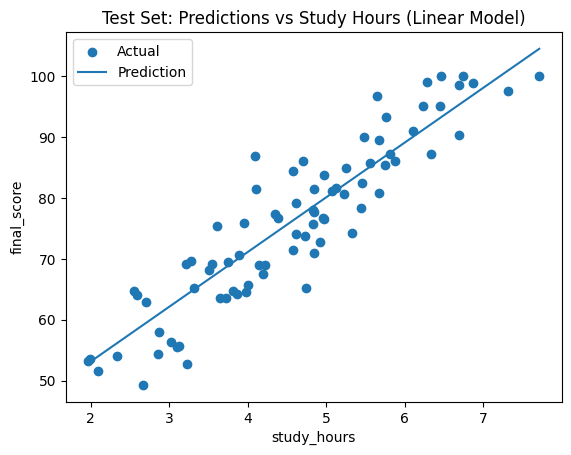

In [10]:

# Sort for line plotting
order = np.argsort(X_test[study_col].values)
X_sorted = X_test[study_col].values[order]
y_sorted_pred = y_pred[order]

plt.figure()
plt.scatter(X_test[study_col], y_test, label='Actual')
plt.plot(X_sorted, y_sorted_pred, label='Prediction')
plt.title('Test Set: Predictions vs Study Hours (Linear Model)')
plt.xlabel(study_col)
plt.ylabel(score_col)
plt.legend()
plt.show()


### 5.2 Residuals Plot
A residuals plot helps reveal patterns the model isn't capturing.

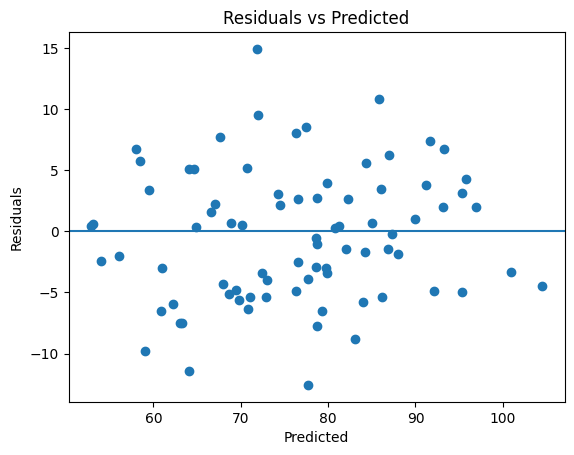

In [11]:

residuals = y_test - y_pred
plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()


## 6. Polynomial Regression (Bonus)
We extend the baseline by adding polynomial features of `study_hours`.
We compare performance across degrees.

In [13]:
results_poly = []
degrees = [2, 3, 4]

for d in degrees:
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=d, include_bias=False)),
        ('lin', LinearRegression())
    ])
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred) # Calculate MSE
    rmse = np.sqrt(mse) # Calculate RMSE manually
    r2 = r2_score(y_test, pred)
    results_poly.append({'degree': d, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

pd.DataFrame(results_poly)

,degree,MAE,RMSE,R2
0,2,4.531204,5.496217,0.834140
1,3,4.503045,5.453536,0.836706
2,4,4.449254,5.399182,0.839945


### 6.1 Plot Polynomial Fit (best degree)
We choose the polynomial degree with the best R² and plot its curve.

Best polynomial degree by R^2: 4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


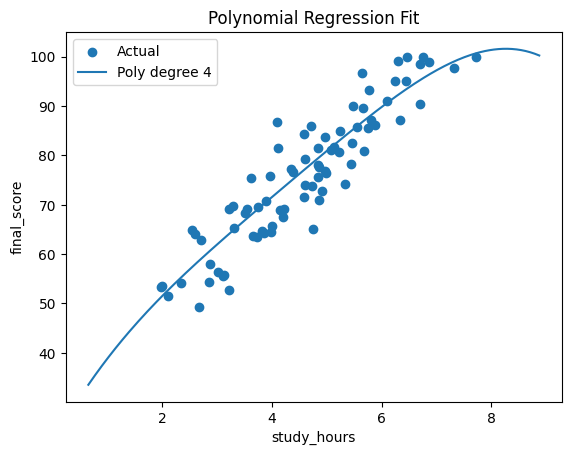

In [14]:

df_poly = pd.DataFrame(results_poly)
best_degree = df_poly.sort_values('R2', ascending=False).iloc[0]['degree']
print(f'Best polynomial degree by R^2: {int(best_degree)}')

best_model = Pipeline([
    ('poly', PolynomialFeatures(degree=int(best_degree), include_bias=False)),
    ('lin', LinearRegression())
])
best_model.fit(X_train, y_train)

# Smooth curve over a grid
x_grid = np.linspace(X[study_col].min(), X[study_col].max(), 200).reshape(-1, 1)
y_grid_pred = best_model.predict(x_grid)

plt.figure()
plt.scatter(X_test[study_col], y_test, label='Actual')
plt.plot(x_grid, y_grid_pred, label=f'Poly degree {int(best_degree)}')
plt.title('Polynomial Regression Fit')
plt.xlabel(study_col)
plt.ylabel(score_col)
plt.legend()
plt.show()


## 7. Feature Experimentation (Bonus)
If your dataset contains other potentially predictive features like `sleep`, `participation`, `attendance`, etc., this section shows how to include them. We auto-detect some common column names if they exist.

In [15]:

# Candidate columns to include if present
candidates = {
    'sleep': ['sleep', 'sleep_hours', 'sleeping_hours'],
    'attendance': ['attendance', 'attendence', 'attendance_percentage'],
    'participation': ['participation', 'class_participation', 'discussion'],
    'age': ['age'],
    'gpa': ['gpa', 'cgpa'],
}

def detect_columns(candidates, df_cols):
    found = {}
    for key, names in candidates.items():
        col = None
        for nm in names:
            for c in df_cols:
                if c.lower() == nm.lower():
                    col = c
                    break
            if col is not None:
                break
        if col is not None:
            found[key] = col
    return found

found_feats = detect_columns(candidates, df.columns)
found_feats


{'sleep': 'sleep_hours',
 'attendance': 'attendance',
 'participation': 'participation'}

In [17]:
# Build a feature set: study_hours + any found optional features
feature_cols = [study_col] + list(found_feats.values())
print('Using feature columns:', feature_cols)

X_multi = df[feature_cols].copy()
y_multi = df[score_col].copy()

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

# Simple pipeline: scale numeric features then Linear Regression
numeric_features = feature_cols
preprocess = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_features)],
    remainder='drop'
)

multi_model = Pipeline([
    ('prep', preprocess),
    ('lin', LinearRegression())
])

multi_model.fit(X_train_m, y_train_m)
y_pred_m = multi_model.predict(X_test_m)

mae_m = mean_absolute_error(y_test_m, y_pred_m)
mse_m = mean_squared_error(y_test_m, y_pred_m) # Calculate MSE
rmse_m = np.sqrt(mse_m) # Calculate RMSE manually
r2_m = r2_score(y_test_m, y_pred_m)

print('--- Linear Regression with Extra Features ---')
print(f'Features: {feature_cols}')
print(f'MAE : {mae_m:.3f}')
print(f'RMSE: {rmse_m:.3f}')
print(f'R^2 : {r2_m:.3f}')

Using feature columns: ['study_hours', 'sleep_hours', 'attendance', 'participation']
--- Linear Regression with Extra Features ---
Features: ['study_hours', 'sleep_hours', 'attendance', 'participation']
MAE : 3.641
RMSE: 4.540
R^2 : 0.887


### 7.1 Compare All Models
Quick comparison: Baseline Linear, Best Polynomial (study only), and Linear with Extra Features (if available).

In [19]:
# Recompute baseline metrics in case the kernel was restarted
lin_reg = LinearRegression().fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
baseline = {
    'Model': 'Linear (study only)',
    'MAE': mean_absolute_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)), # Calculate RMSE manually
    'R2': r2_score(y_test, y_pred)
}

# Best polynomial (from previous step)
df_poly = pd.DataFrame(results_poly) if 'results_poly' in globals() else pd.DataFrame()
if not df_poly.empty:
    best_degree = df_poly.sort_values('R2', ascending=False).iloc[0]['degree']
    model_poly_best = Pipeline([('poly', PolynomialFeatures(degree=int(best_degree), include_bias=False)), ('lin', LinearRegression())])
    model_poly_best.fit(X_train, y_train)
    pred_poly = model_poly_best.predict(X_test)
    poly_best = {
        'Model': f'Polynomial (deg={int(best_degree)})',
        'MAE': mean_absolute_error(y_test, pred_poly),
        'RMSE': np.sqrt(mean_squared_error(y_test, pred_poly)), # Calculate RMSE manually
        'R2': r2_score(y_test, pred_poly)
    }
else:
    poly_best = {'Model':'Polynomial', 'MAE':np.nan, 'RMSE':np.nan, 'R2':np.nan}

# Multi-feature model (if extra features used)
if 'y_pred_m' in globals():
    multi = {
        'Model': 'Linear (study + extras)',
        'MAE': mae_m,
        'RMSE': rmse_m,
        'R2': r2_m
    }
else:
    multi = {'Model':'Linear (study + extras)', 'MAE':np.nan, 'RMSE':np.nan, 'R2':np.nan}

comparison_df = pd.DataFrame([baseline, poly_best, multi])
comparison_df

,Model,MAE,RMSE,R2
0,Linear (study only),4.437367,5.380292,0.841063
1,Polynomial (deg=4),4.449254,5.399182,0.839945
2,Linear (study + extras),3.641256,4.539502,0.886856


## 8. Save Artifacts (Optional)
Save the processed dataset and trained models if you need to reuse them later.

In [20]:

from joblib import dump

# Save processed data sample
df.to_csv('processed_student_data.csv', index=False)
print('Saved processed data -> processed_student_data.csv')

# Save baseline linear model
dump(lin_reg, 'linear_model_study_only.joblib')
print('Saved baseline model -> linear_model_study_only.joblib')

# Save best polynomial model (if available)
if 'model_poly_best' in globals():
    dump(model_poly_best, 'polynomial_best_model.joblib')
    print('Saved polynomial model -> polynomial_best_model.joblib')

# Save multi-feature model (if available)
if 'multi_model' in globals():
    dump(multi_model, 'linear_model_multi_features.joblib')
    print('Saved multi-feature model -> linear_model_multi_features.joblib')


Saved processed data -> processed_student_data.csv
Saved baseline model -> linear_model_study_only.joblib
Saved polynomial model -> polynomial_best_model.joblib
Saved multi-feature model -> linear_model_multi_features.joblib
